In [1]:
# referensi: https://www.kaggle.com/code/paulojunqueira/mnist-with-pytorch-and-transfer-learning-timm

import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset,ConcatDataset,DataLoader
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

d:\disertasi\handGestureDetection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
class confiFile():
    """Configuration class for easy parametrization"""
    
    #Pretrained model with timm
    model = 'resnet50'
    epochs = 30
    
    in_chans = 1
    num_classes = 24
    learning_rate = 1e-3
    
    val_size = 0.3
    batch_size = 128
    
CFG = confiFile()

In [3]:
class MNISTdataset(Dataset):
    """V2"""
    def __init__(self, data, transform = None):
        
        self.X = (data.drop('label', axis =1).values/255).reshape((-1, 28, 28,1))
        self.y = data['label'].values.reshape(-1,1)
        self.n_samples = data.shape[0]
        
        self.transform = transform 
    
    def __getitem__(self, index):
        X,y = self.X[index], self.y[index]
        
        if self.transform:
            X  = self.transform(X)
            
        return (X,y)
        
    def __len__(self):
        return self.n_samples

In [4]:
train_df = pd.read_csv('dataHandSign/archive/sign_mnist_train/sign_mnist_train.csv',dtype=np.float32)
compose_agu_1 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(degrees=(300,350), fill=(0,))])
compose_agu_2 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(degrees=(0,45), fill=(0,))])
compose_original = transforms.Compose([transforms.ToTensor()])

In [5]:
dataset_original = MNISTdataset(train_df,transform = compose_original)
dataset_aug_1 = MNISTdataset(train_df,transform = compose_agu_1)
dataset_aug_2 = MNISTdataset(train_df,transform = compose_agu_2)
increased_dataset = ConcatDataset([dataset_aug_1,dataset_aug_2,dataset_original])


In [6]:
#Spliting Data
X_train, X_val, = train_test_split(increased_dataset, test_size = CFG.val_size, random_state = 666)

# Creating Datasets Loaders
train_loader = DataLoader(X_train, batch_size  = CFG.batch_size,  shuffle = True)
val_loader = DataLoader(X_val, batch_size  = CFG.batch_size,  shuffle = True)

C:\Users\giosp\AppData\Local\Temp\ipykernel_6208\3403339041.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[0,i].set_title(int(y))
C:\Users\giosp\AppData\Local\Temp\ipykernel_6208\3403339041.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[1,i].set_title(int(y))


Text(0, 0.5, 'Original Images')

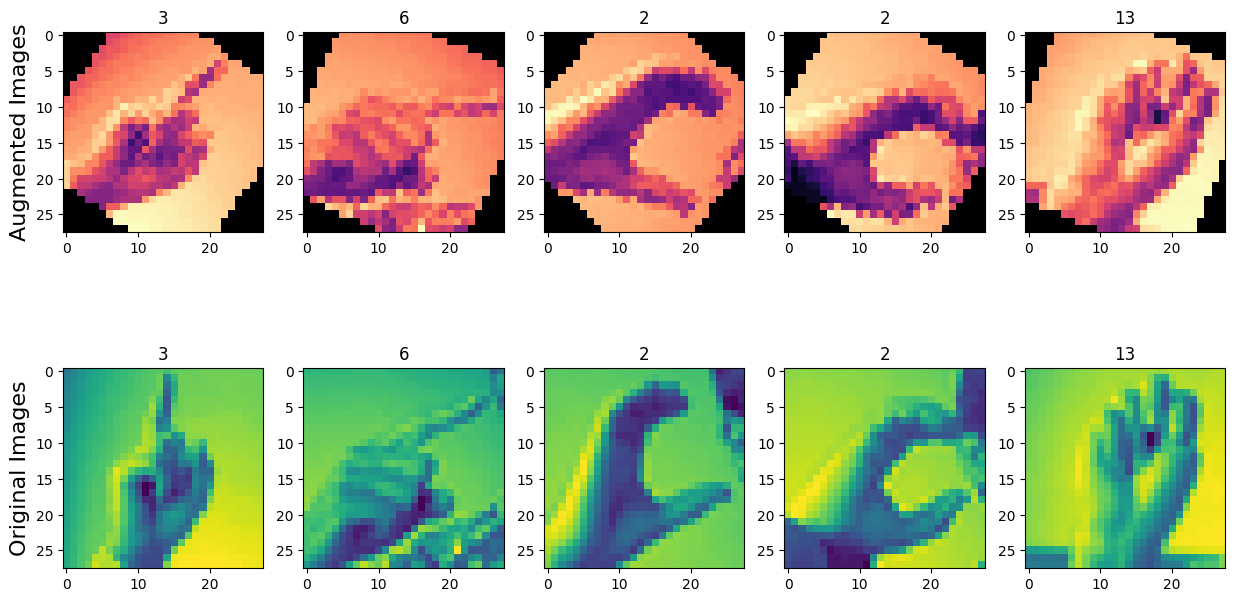

In [ ]:
#Visualizing some examples in the training dataset X
fig, ax = plt.subplots(nrows = 2, ncols = 5,  figsize = (15,8))
for i in range(5):
    image, y = dataset_aug_1.__getitem__(i)
    ax[0,i].imshow(image.squeeze(), cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)
    ax[0,i].set_title(int(y))
    
    image, y = dataset_original.__getitem__(i)
    ax[1,i].imshow(image.squeeze(), cmap="viridis") # Squeeze removes length (1,28,28) -> (28,28)
    ax[1,i].set_title(int(y))

ax[0,0].set_ylabel('Augmented Images',fontdict= {'fontsize':16})
ax[1,0].set_ylabel('Original Images', fontdict= {'fontsize':16})

Model

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Training Function
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def train_(model, optmizer, loss_func, train_loader, device):
    """Function to train the model"""
    train_loss = 0.0
    train_correct = 0
    size_sampler = len(train_loader.sampler)
    
    for i, (images, labels) in enumerate(train_loader):
        
        # Pushing to device (cuda or CPU)
        images, labels = images.to(device), labels.to(device)
        
        #zeroing gradiants
        optmizer.zero_grad()
        
        #feedfoard
        y_hat = model(images)
        
        #Compute loss 
        loss = loss_func(y_hat, labels.long().squeeze())
        
        #Compute backpropagation
        loss.backward()
        
        #updating weights
        optmizer.step()
        
        # loss and correct values compute
        train_loss +=loss.item() * images.size(0)
        _ , pred = torch.max(y_hat.data, 1)
        train_correct +=sum(pred == labels.long().squeeze()).sum().item()
        
    return np.round(train_loss/size_sampler,4), np.round(train_correct*100./size_sampler,3)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Validation Function
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def validation_(model, loss_func,val_loader, device):
    val_loss = 0.0
    val_correct = 0
    size_sampler = len(val_loader.sampler)
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):

            images, labels = images.to(device), labels.to(device)
            y_hat = model(images)
            loss = loss_func(y_hat, labels.long().squeeze())
            
            val_loss +=loss.item() * images.size(0)
            _ , pred = torch.max(y_hat.data, 1)
            val_correct +=(pred == labels.long().squeeze()).sum().item()
        
    return np.round(val_loss/size_sampler,4), np.round(val_correct*100./size_sampler,3)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Main Training
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def train_model(model,optmizer, loss_func,scheduler, train_loader, val_loader, epochs, device, log = True):
    
    best_acc = 0
    
    
    print('Initializing Training...')
    
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    
    for i in range(epochs):
        
        train_loss, train_acc=  train_(model, optmizer, loss_func, train_loader,device)
        val_loss, val_acc = validation_(model, loss_func,val_loader, device)
        
        scheduler.step()
        
        if val_acc > best_acc:
            print(f'>> Saving Best Model with Val Acc: Old: {best_acc} | New: {val_acc}')
            best_model = copy.deepcopy(model)
            best_acc = val_acc
        
        
        if log and ((i+1)%2 == 0):
            print(f'> Epochs: {i+1}/{epochs} - Train Loss: {train_loss} - Train Acc: {train_acc} - Val Loss: {val_loss} - Val Acc: {val_acc}')
        
        #Saving infos on a history dict
        for key, value in zip(history, [train_loss,val_loss,train_acc,val_acc]):
            history[key].append(value)
    
    
    
    print('...End Traing')
            
    return history,best_model

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Ploting graphics
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def plot_history(history):
    
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    
    #Loss
    sns.lineplot(data = history['train_loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title('Loss')
    #Accuracy
    sns.lineplot(data = history['train_acc'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history['val_acc'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title('Accuracy')

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Execute training
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

model = timm.create_model(CFG.model, 
                          pretrained = True,
                          in_chans = CFG.in_chans, 
                          num_classes = CFG.num_classes)

model = model.to(device)

# # Same as using the model.fc (for resnet only) but easier as it can change in other models
# print(model.get_classifier())

# #checking the global pooling from timm
# print(model.global_pool)


optmizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
loss_func =  nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optmizer, step_size=5, gamma=0.1)

history,best_model = train_model(model = model, 
                    optmizer = optmizer, 
                    loss_func = loss_func,
                    scheduler = scheduler,
                    train_loader = train_loader,
                    val_loader = val_loader,
                    epochs = CFG.epochs,
                    device = device)

#ploting results
plot_history(history)

model.safetensors: 100%|██████████| 102M/102M [00:10<00:00, 9.55MB/s] 
d:\disertasi\handGestureDetection\.venv\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\giosp\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Initializing Training...


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
